In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import os
import time
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random

In [2]:
def plot_metrics(train, val, test, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric
        - val_loss (list): Validation metric
        - test_loss (list): Test tmetric
        - epochs (int): The number of epochs.
    """
    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(8, 8))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    plt.plot(range(1, epochs + 1), test, label='Test', color=sns.color_palette("pastel")[2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"{title}")
    plt.legend()
    plt.show()

In [3]:
class DataSampler:
    """
    DataSampler: Manages sampling and splitting of the USNW-NB15 dataset. Returns a training, validation, and test set.

    Initialisation:
        - train (None): The attributes that stores the train set.
        - val (None): The attributes that stores the validation set.
        - test (None): The attributes that stores the test set.
    """

    def __init__(self):
        self.train = None
        self.val = None
        self.test = None

    def sample_data(self, data, type_of, rs):
        """
        sample_data: Combines the USNW-NB15 training and test set, shuffles them, then splits into train, validation, and test set.

        Parameters:
            - data (string): The dataset to use (currently only USNW-NB15 is supported).
            - type_of (string):  The type of sampling.
            - rs (int): The random seed for the sampler.
        """

        if data == 'train_test':
            train = pd.read_csv('UNSW_NB15_training-set.csv')
            test = pd.read_csv('UNSW_NB15_testing-set.csv')
            data = pd.concat([train, test])
        if type_of == 'full_random':
            data = data.sample(frac=1, random_state=rs).reset_index(drop=True)
            total_samples = len(data)
            val_samples = int(total_samples * 0.15)
            test_samples = int(total_samples * 0.15)
            self.val = data.iloc[:val_samples]
            self.test = data.iloc[val_samples:val_samples+test_samples]
            self.train = data.iloc[val_samples+test_samples:]
            return self.train, self.val, self.test

        if type_of == 'full_upsample':
            pass


In [4]:
class DataManager:
    """
    DataManager: Help manage the pre-processing of the USNW-NB15 dataset for an LSTM.

    Initialisation:
        - train (pd.Dataframe): The training data.
        - val (pd.Dataframe): The validation data.
        - test (pd.Dataframe): The teting data.
        - type_of (string): Specify if multiclass or other (currently only multi-class is supported).
    """
    def __init__(self, train, val, test, type_of):
        self.train = train
        self.val = val
        self.test = test
        if type_of == 'multi':
            for i in [self.train, self.val, self.test]:
                i.drop(columns=['id', 'label'], inplace=True)    
            self.label = 'attack_cat'
        
    def label_encode(self):
        """
        label_encode: label encodes the categorical columns. Preset to 'proto', 'state', and 'service' and the label.

        NOTE: This can have conflicts depending on what seed is used in the sampler.

        """

        data = [self.train, self.val, self.test]
        columns = ['proto', 'state', 'service', self.label]
        encoder = LabelEncoder()
        for col in columns:
            for df in data:
                df[col] = encoder.fit_transform(df[col])
        self.train, self.val, self.test = data
    
    def onehot_encode(self):
        """
        onehot_encode: One-hot encodes the categorical columns. Preset to 'proto', 'state', and 'service'. Label encodes the target.

        NOTE: This can have conflicts depending on what seed is used in the sampler.
        """
        columns = ['proto', 'state', 'service']

        encoder2 = LabelEncoder()
        encoder = OneHotEncoder(sparse_output=False, dtype='float32')

        for col in columns:
            encoded_train = encoder.fit_transform(self.train[[col]])
            encoded_val = encoder.transform(self.val[[col]])
            encoded_test = encoder.transform(self.test[[col]])
            encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col]), index=self.train.index)
            encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out([col]), index=self.val.index)
            encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col]), index=self.test.index)
            self.train = pd.concat([self.train.drop(columns=[col]), encoded_train_df], axis=1)
            self.val = pd.concat([self.val.drop(columns=[col]), encoded_val_df], axis=1)
            self.test = pd.concat([self.test.drop(columns=[col]), encoded_test_df], axis=1)

        encoder = LabelEncoder()
        for df in [self.train, self.val, self.test]:
            df[self.label] = encoder.fit_transform(df[self.label])


    def standardise(self, type_of):
        """
        standardise: Standardises the features of the train and test datasets.

        Parameters:
            - type_of (string): Choose the standardisation ('standard' or 'minmax').
        """
        train_features = self.train.drop(columns=[self.label])
        val_features = self.val.drop(columns=[self.label])
        test_features = self.test.drop(columns=[self.label])
        train_label = self.train[self.label]
        val_label = self.val[self.label]
        test_label = self.test[self.label]
        if type_of == 'minmax':
            scaler = MinMaxScaler()
        elif type_of == 'standard':
            scaler = StandardScaler()
        scaled_train = scaler.fit_transform(train_features)
        scaled_val = scaler.transform(val_features)
        scaled_test = scaler.transform(test_features)
        self.train = pd.DataFrame(scaled_train, columns=train_features.columns, index=self.train.index)
        self.train[self.label] = train_label
        self.val = pd.DataFrame(scaled_val, columns=val_features.columns, index=self.val.index)
        self.val[self.label] = val_label
        self.test = pd.DataFrame(scaled_test, columns=test_features.columns, index=self.test.index)
        self.test[self.label] = test_label

    def get_sequence(self, batch_size):
        """
        get_sequence: Converts the Dtaframe to a sequence for each row and the corresponding label.
        
        Parameters:
            - batch_size (int): The batch size to use in DataLoader.

        Returns:
            - train_loader (DataLoader): Dataloader for the training data.
            - val_loader (DataLoader): Dataloader for the validation data.
            - test_loader (DataLoader): Dataloader for the test data.
        """
        
        train_seq = torch.tensor(self.train.drop(columns=[self.label]).values, dtype=torch.float32)
        val_seq = torch.tensor(self.val.drop(columns=[self.label]).values, dtype=torch.float32)
        test_seq = torch.tensor(self.test.drop(columns=[self.label]).values, dtype=torch.float32)
        train_label = torch.tensor(self.train[self.label].values, dtype=torch.long)
        val_label = torch.tensor(self.val[self.label].values, dtype=torch.long)
        test_label = torch.tensor(self.test[self.label].values, dtype=torch.long)

        # Add dimension for LSTM.
        train_seq = train_seq.unsqueeze(1)
        val_seq = val_seq.unsqueeze(1)
        test_seq = test_seq.unsqueeze(1)

        train_dataset = TensorDataset(train_seq, train_label)
        val_dataset = TensorDataset(val_seq, val_label)
        test_dataset = TensorDataset(test_seq, test_label)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader
    
    def get_weights(self, type_of):
        """
        get_weights: Calculate the weights of the labels for the given dataset. Used in Cross Entropy Loss criterion.
        
        Parameters:
            - type_of (string): The dataset to use (train, val, test).

        Returns:
            - class_weights (tensor): The class weights for the label.
        """
        if type_of == 'train':
            data = self.train
        elif type_of == 'val':
            data = self.val
        elif type_of == 'test':
            data = self.test
        labels = data[self.label].values
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        return torch.tensor(class_weights, dtype=torch.float)

In [5]:

class SimpleLSTM(nn.Module):
    """
    SimpleLSTM: An LSTM Model customised for the USNW-NB15 dataset. Uses a fully connected layer to output the predictions.

    Parameters:
        - nn.Module (nn.Module): The torch Neural Network module.
    
    Initialisation:
        - n_features (int): Number of features:
        - hidden_size (int): Hidden layer size.
        - n_layers (int): Number of hidden layers.
        - n_labels (int): Number of labels.
    """
    def __init__(self, n_features, hidden_size, n_layers, n_labels, criterion, learning_rate):
        super(SimpleLSTM, self).__init__()
        # LSTM Layer (doubled).
        self.lstm = nn.LSTM(n_features, 
                            hidden_size, 
                            n_layers, 
                            batch_first=True)
        # Fully connected layer to the number of labels.
        self.fc = nn.Linear(hidden_size, n_labels)
        self.learning_rate = learning_rate
        self.optimizer = None
        self.criterion = criterion
        self.save_dir = 'saved_model/lstm/'
        # Metrics to track
        self.loss = []
        self.accuracy = []
        self.f1 = []
        self.epoch_time = []
        self.val_loss = []
        self.val_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

    def forward(self, x):
        """
        forward: The forward function for calls the lstm layer and collects the last hidden state. 
        Finally uses a fully connected layer to output the logits for softmax.

        Parameters:
            - x (array): The batch array from the Dataloader.

        Returns:
            - out (array): The logits (10) of the fully connected layer.

        NOTE: We are using row-by to same label sequence.
        """
        lstm_out, (hn, cn) = self.lstm(x)
        # The last hidden state.
        final_hidden_state = hn[-1]
        # Fully connected to label count.
        out = self.fc(final_hidden_state)
        return out

    def run(self, train_loader, val_loader, test_loader, epochs, save_factor):
        """
        run: Go through each epoch and do a forward pass then backpropagate using Cross Entropy Loss and Adam Optimiser to adjust the gradient. 
        Then evaluate the epoch using a validation set. At the end of all epochs, evaluate using the test set.

        Parameters:
            - train_loader (Dataloader): The Dataloader with the training set and labels.
            - val_loader (Dataloader): The Dataloader with the validation set and labels.
            - test_loader (Dataloader): The Dataloader with the test set and labels.
            - epochs (int): The number of epochs to train.
            - save_factor (int): The factor at which epoch to save the model weights.
        """
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        for epoch in range(epochs):
            start_time = time.time()
            # Set to training mode.
            self.train()
            # Reset metrics for epoch.
            running_loss = 0.0
            correct = 0
            total = 0
            all_preds = []
            all_labels = []
            with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tqmbar:
                for batch_idx, (inputs, labels) in enumerate(tqmbar):
                    inputs, labels = inputs.to(device), labels.to(device)
                    # Reset gradient.
                    self.optimizer.zero_grad()
                    # Forward.
                    outputs = self(inputs)
                    loss = self.criterion(outputs, labels)
                    # Backpropagation.
                    loss.backward()
                    self.optimizer.step()
                    # Cumulative loss.
                    running_loss += loss.item()
                    # Get highest probability label.
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            avg_loss = running_loss / len(train_loader)
            accuracy = 100 * correct / total
            if len(all_preds) > 0:
                f1 = f1_score(all_labels, all_preds, average='weighted')
            else:
                f1 = 0
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}")
            self.loss.append(avg_loss)
            self.accuracy.append(accuracy)
            self.f1.append(f1)
            self.epoch_time.append(time.time() - start_time)

            # Validation after each epoch
            val_loss, val_accuracy, val_f1 = self.validate(val_loader)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.2f}")
            self.val_loss.append(val_loss)
            self.val_accuracy.append(val_accuracy)

            # Test after each epoch
            test_loss, test_accuracy, test_f1 = self.test(test_loader)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.2f}")
            self.test_loss.append(test_loss)
            self.test_accuracy.append(test_accuracy)

            # Save model at specified intervals.
            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def validate(self, data_loader):
        """
        validate: The validation run of the LSTM model.

        Parameters:
            - data_loader (Dataloader): The Dataloader of validation set.
        
        Returns:
            - loss (float): The average loss of the validation run.
            - accuracy (float): The accuracy of validation run.
            - f1 (float): The F1 score (macro) of validation run.
        """
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        avg_loss = running_loss / len(data_loader)
        accuracy = 100 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return avg_loss, accuracy, f1

    def test(self, test_loader):
        """
        test: The test run of the LSTM model.

        Parameters:
            - data_loader (Dataloader): The Dataloader of test set.
        
        Returns:
            - loss (float): The average loss of the test run.
            - accuracy (float): The accuracy of test run.
            - f1 (float): The F1 score (macro) of test run.
        """
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = running_loss / len(test_loader)
        accuracy = 100 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return avg_loss, accuracy, f1

    def predict(self, input_data):
        """
        predict: Predicts the class for the input.

        Parameters:
            - input_data (tensor): The input data.
        
        Returns:
            - predicted (tensor): The predicted labels.
        """
        self.eval()
        input_data = input_data.to(device)
        with torch.no_grad():
            output = self(input_data)
            _, predicted = torch.max(output, 1)
        return predicted

    def save_model(self, epoch):
        """
        save_model: Save the model's state and metrics to directory for the given epoch.

        Parameters:
            - epoch (int): The current epoch.
        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.criterion,
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")

    def load_model(self, epoch):
        """
        load_model: Load a saved model from the directory.

        Parameters:
            - epoch (int): The epoch to load.
    
        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            self.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [6]:
# Sample Full Random Datasets.
sampler = DataSampler()
train, val, test = sampler.sample_data('train_test', 'full_random', 42)
dm = DataManager(train, val, test, 'multi')
batch_size = 32
dm.label_encode()
#dm.onehot_encode()
dm.standardise('standard')
train_loader, val_loader, test_loader = dm.get_sequence(batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 42
hidden_size = 128
n_layers = 2
n_labels = 10
# Weights does not help with the current sample.
#weights = dm.get_weights('train')
model = SimpleLSTM(n_features, hidden_size, n_layers, n_labels, nn.CrossEntropyLoss(), 0.001).to(device)
# Datasets, Epochs, and Save Factor.
# NOTE: Save Factor is set above epochs as models state_dict can be large in size.
model.run(train_loader, val_loader, test_loader, 20, 100)

Epoch 1/20: 100%|██████████| 5637/5637 [00:16<00:00, 341.17batch/s]


Epoch [1/20], Loss: 0.6127, Accuracy: 76.29%, F1 Score: 0.74
Validation Loss: 0.5864, Validation Accuracy: 76.39%, Validation F1 Score: 0.73
Test Loss: 0.8927, Test Accuracy: 71.61%, Test F1 Score: 0.66


Epoch 2/20: 100%|██████████| 5637/5637 [00:15<00:00, 358.63batch/s]


Epoch [2/20], Loss: 0.5190, Accuracy: 79.13%, F1 Score: 0.77
Validation Loss: 0.5605, Validation Accuracy: 78.09%, Validation F1 Score: 0.76
Test Loss: 0.9166, Test Accuracy: 70.99%, Test F1 Score: 0.65


Epoch 3/20: 100%|██████████| 5637/5637 [00:16<00:00, 350.23batch/s]


Epoch [3/20], Loss: 0.4971, Accuracy: 79.89%, F1 Score: 0.78
Validation Loss: 0.5206, Validation Accuracy: 79.47%, Validation F1 Score: 0.78
Test Loss: 0.7915, Test Accuracy: 73.15%, Test F1 Score: 0.68


Epoch 4/20: 100%|██████████| 5637/5637 [00:16<00:00, 345.23batch/s]


Epoch [4/20], Loss: 0.4832, Accuracy: 80.39%, F1 Score: 0.78
Validation Loss: 0.5142, Validation Accuracy: 79.30%, Validation F1 Score: 0.77
Test Loss: 0.7937, Test Accuracy: 73.04%, Test F1 Score: 0.68


Epoch 5/20: 100%|██████████| 5637/5637 [00:16<00:00, 350.40batch/s]


Epoch [5/20], Loss: 0.4718, Accuracy: 80.79%, F1 Score: 0.79
Validation Loss: 0.5097, Validation Accuracy: 79.46%, Validation F1 Score: 0.79
Test Loss: 0.8843, Test Accuracy: 71.48%, Test F1 Score: 0.67


Epoch 6/20: 100%|██████████| 5637/5637 [00:16<00:00, 343.60batch/s]


Epoch [6/20], Loss: 0.4645, Accuracy: 81.06%, F1 Score: 0.79
Validation Loss: 0.4949, Validation Accuracy: 79.92%, Validation F1 Score: 0.78
Test Loss: 0.8158, Test Accuracy: 72.57%, Test F1 Score: 0.68


Epoch 7/20: 100%|██████████| 5637/5637 [00:17<00:00, 319.14batch/s]


Epoch [7/20], Loss: 0.4579, Accuracy: 81.28%, F1 Score: 0.79
Validation Loss: 0.4772, Validation Accuracy: 80.89%, Validation F1 Score: 0.78
Test Loss: 0.8407, Test Accuracy: 72.49%, Test F1 Score: 0.68


Epoch 8/20: 100%|██████████| 5637/5637 [00:15<00:00, 352.40batch/s]


Epoch [8/20], Loss: 0.4525, Accuracy: 81.46%, F1 Score: 0.80
Validation Loss: 0.4779, Validation Accuracy: 80.48%, Validation F1 Score: 0.78
Test Loss: 0.8187, Test Accuracy: 72.04%, Test F1 Score: 0.68


Epoch 9/20: 100%|██████████| 5637/5637 [00:17<00:00, 327.10batch/s]


Epoch [9/20], Loss: 0.4482, Accuracy: 81.58%, F1 Score: 0.80
Validation Loss: 0.4960, Validation Accuracy: 79.82%, Validation F1 Score: 0.79
Test Loss: 0.8365, Test Accuracy: 71.46%, Test F1 Score: 0.68


Epoch 10/20: 100%|██████████| 5637/5637 [00:16<00:00, 332.11batch/s]


Epoch [10/20], Loss: 0.4440, Accuracy: 81.74%, F1 Score: 0.80
Validation Loss: 0.4740, Validation Accuracy: 80.82%, Validation F1 Score: 0.78
Test Loss: 0.8087, Test Accuracy: 71.91%, Test F1 Score: 0.68


Epoch 11/20: 100%|██████████| 5637/5637 [00:17<00:00, 322.33batch/s]


Epoch [11/20], Loss: 0.4400, Accuracy: 81.86%, F1 Score: 0.80
Validation Loss: 0.4679, Validation Accuracy: 80.95%, Validation F1 Score: 0.79
Test Loss: 0.7946, Test Accuracy: 72.38%, Test F1 Score: 0.68


Epoch 12/20: 100%|██████████| 5637/5637 [00:16<00:00, 344.47batch/s]


Epoch [12/20], Loss: 0.4365, Accuracy: 82.01%, F1 Score: 0.80
Validation Loss: 0.4783, Validation Accuracy: 80.47%, Validation F1 Score: 0.79
Test Loss: 0.8426, Test Accuracy: 70.53%, Test F1 Score: 0.66


Epoch 13/20: 100%|██████████| 5637/5637 [00:17<00:00, 331.37batch/s]


Epoch [13/20], Loss: 0.4335, Accuracy: 82.08%, F1 Score: 0.80
Validation Loss: 0.4712, Validation Accuracy: 81.12%, Validation F1 Score: 0.79
Test Loss: 0.9269, Test Accuracy: 69.71%, Test F1 Score: 0.66


Epoch 14/20: 100%|██████████| 5637/5637 [00:17<00:00, 328.55batch/s]


Epoch [14/20], Loss: 0.4303, Accuracy: 82.18%, F1 Score: 0.80
Validation Loss: 0.4750, Validation Accuracy: 80.81%, Validation F1 Score: 0.79
Test Loss: 0.9157, Test Accuracy: 69.91%, Test F1 Score: 0.67


Epoch 15/20: 100%|██████████| 5637/5637 [00:17<00:00, 327.15batch/s]


Epoch [15/20], Loss: 0.4278, Accuracy: 82.28%, F1 Score: 0.81
Validation Loss: 0.4715, Validation Accuracy: 80.95%, Validation F1 Score: 0.79
Test Loss: 0.9444, Test Accuracy: 69.73%, Test F1 Score: 0.67


Epoch 16/20: 100%|██████████| 5637/5637 [00:18<00:00, 311.94batch/s]


Epoch [16/20], Loss: 0.4250, Accuracy: 82.35%, F1 Score: 0.81
Validation Loss: 0.4814, Validation Accuracy: 80.42%, Validation F1 Score: 0.79
Test Loss: 0.9069, Test Accuracy: 70.61%, Test F1 Score: 0.69


Epoch 17/20: 100%|██████████| 5637/5637 [00:17<00:00, 322.81batch/s]


Epoch [17/20], Loss: 0.4229, Accuracy: 82.49%, F1 Score: 0.81
Validation Loss: 0.4699, Validation Accuracy: 81.12%, Validation F1 Score: 0.79
Test Loss: 0.9510, Test Accuracy: 67.74%, Test F1 Score: 0.65


Epoch 18/20: 100%|██████████| 5637/5637 [00:17<00:00, 330.93batch/s]


Epoch [18/20], Loss: 0.4213, Accuracy: 82.55%, F1 Score: 0.81
Validation Loss: 0.4836, Validation Accuracy: 80.43%, Validation F1 Score: 0.79
Test Loss: 0.9424, Test Accuracy: 68.28%, Test F1 Score: 0.67


Epoch 19/20: 100%|██████████| 5637/5637 [00:17<00:00, 321.39batch/s]


Epoch [19/20], Loss: 0.4184, Accuracy: 82.66%, F1 Score: 0.81
Validation Loss: 0.4735, Validation Accuracy: 80.52%, Validation F1 Score: 0.80
Test Loss: 0.8853, Test Accuracy: 70.07%, Test F1 Score: 0.67


Epoch 20/20: 100%|██████████| 5637/5637 [00:17<00:00, 322.55batch/s]


Epoch [20/20], Loss: 0.4164, Accuracy: 82.70%, F1 Score: 0.81
Validation Loss: 0.4710, Validation Accuracy: 80.83%, Validation F1 Score: 0.79
Test Loss: 0.8765, Test Accuracy: 70.01%, Test F1 Score: 0.68


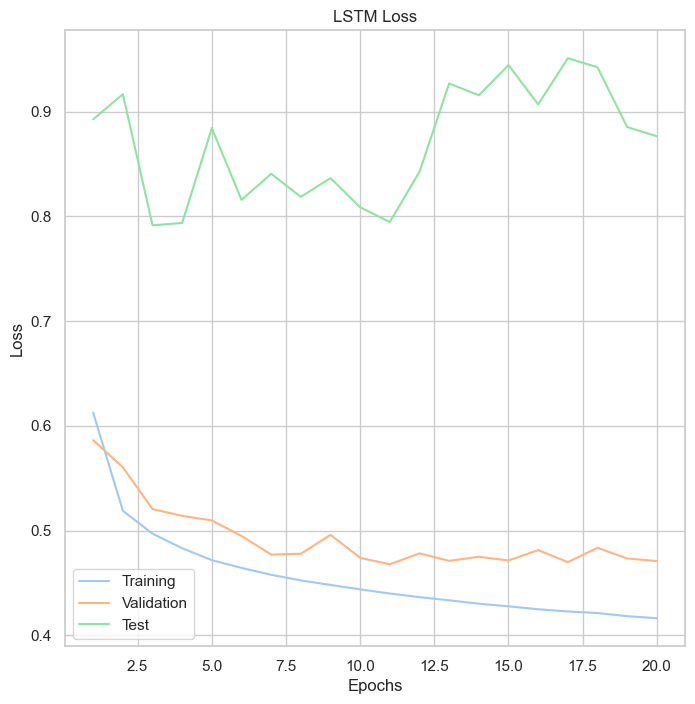

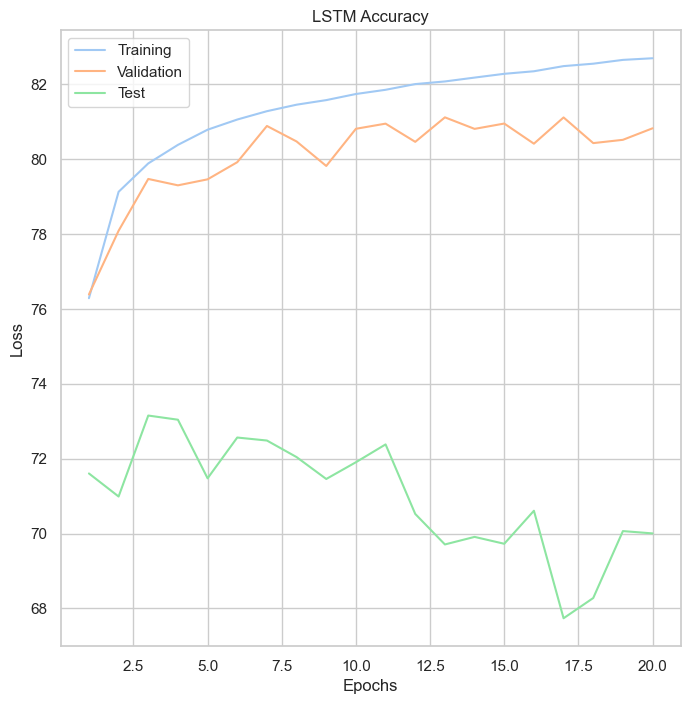

In [7]:
plot_metrics(model.loss, model.val_loss, model.test_loss, 20, 'LSTM Loss')
plot_metrics(model.accuracy, model.val_accuracy, model.test_accuracy, 20, 'LSTM Accuracy')